<a href="https://colab.research.google.com/github/Jay-Wolff/Self-Attention-Language-Model/blob/main/self_attention_language_model_Janissa_Abreu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project


##Objective:
This project aims to enhance the performance of self-attention language model by scaling up the model architecture. The main focus is to implement dropout mechanisms for improved generalization, and to leverage GPU acceleration for efficient training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import time

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2024-05-19 23:04:32--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-05-19 23:04:32 (23.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
max_iters = 5000
learning_rate = 3e-4
block_size = 256 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu' # utilize GPU computing
eval_interval = 100
eval_iters = 200
n_embd = 384 # Affects the size of the bigram model
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)

In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [ ]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
print(len(train_data), len(val_data))

1003854 111540


In [ ]:
# A self-attention block
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)     # process location information
        self.query = nn.Linear(n_embd, head_size, bias=False)   # process token information
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout) # At this moment, the rate is 0

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [ ]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # send data to GPU
    return x, y

In [ ]:
@torch.no_grad() # A function modifier to improve efficiency
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))      # ResNet structure is used
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class SelfAttentionModel4(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
print(device)

cuda


In [ ]:
model = SelfAttentionModel4()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

start_time = time.time()

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

end_time = time.time()

elapsed_time = end_time - start_time


print("\n\nStart Time = " + str(start_time))
print("End Time = " + str(end_time))
print("Elapsed Time = " + str(elapsed_time))

10.788929 M parameters
step 0: train loss 4.3679, val loss 4.3585
step 100: train loss 2.4757, val loss 2.4884
step 200: train loss 2.4235, val loss 2.4428
step 300: train loss 2.3399, val loss 2.3684
step 400: train loss 2.1654, val loss 2.2108
step 500: train loss 2.0296, val loss 2.1012
step 600: train loss 1.9132, val loss 2.0180
step 700: train loss 1.8260, val loss 1.9548
step 800: train loss 1.7415, val loss 1.8818
step 900: train loss 1.6730, val loss 1.8303
step 1000: train loss 1.6209, val loss 1.7895
step 1100: train loss 1.5760, val loss 1.7463
step 1200: train loss 1.5386, val loss 1.7225
step 1300: train loss 1.5072, val loss 1.6857
step 1400: train loss 1.4753, val loss 1.6695
step 1500: train loss 1.4480, val loss 1.6421
step 1600: train loss 1.4285, val loss 1.6325
step 1700: train loss 1.4078, val loss 1.6171
step 1800: train loss 1.3886, val loss 1.5971
step 1900: train loss 1.3698, val loss 1.5866
step 2000: train loss 1.3542, val loss 1.5748
step 2100: train loss 1

In [ ]:
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f'Training time: {hours} hours, {minutes} minutes, {seconds} seconds')

Training time: 0 hours, 21 minutes, 41 seconds


In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=5000)[0].tolist()))


HASTING ELO:
If he, by Saint Church did Nor you wash.
That I dare you are two forsworn:
Most gracious to dread senated.

ISABELLA:
He had you beheld in a back; and, if we should
thou know as the people's very helpe,
Where courselves, with no norgely honour
To the tree aid-fortune. It shall, be as I
must, even so, what do not speak?'
I do beseeming,
Live not borrow to hear it.
Heart I! in thy voice.

ABHORSON:
No, sir; for if my very soul, God he debedity,
Of I love me, fear me for out off,
Inderigricing princessible are and presaged
Till be condirent with prize.

SAMPSON:
O, perovided! be gone, 'tis honest depend.

ROMEO:
Offering and much mores a corse, since of
your parchments, prophecy: all ass
It bid hast
With the prison! pleasure of the conveners.

FRIAR LAURENCE:
My pather know a princinquence gentleman;
Which he determined those thanks,
Might doubly have for Rome and not begg.

ROMEO:
Aland trumpents, with soldiers! It is speak.
Pray you, my liege, like Romeo slain,
Were kinsma

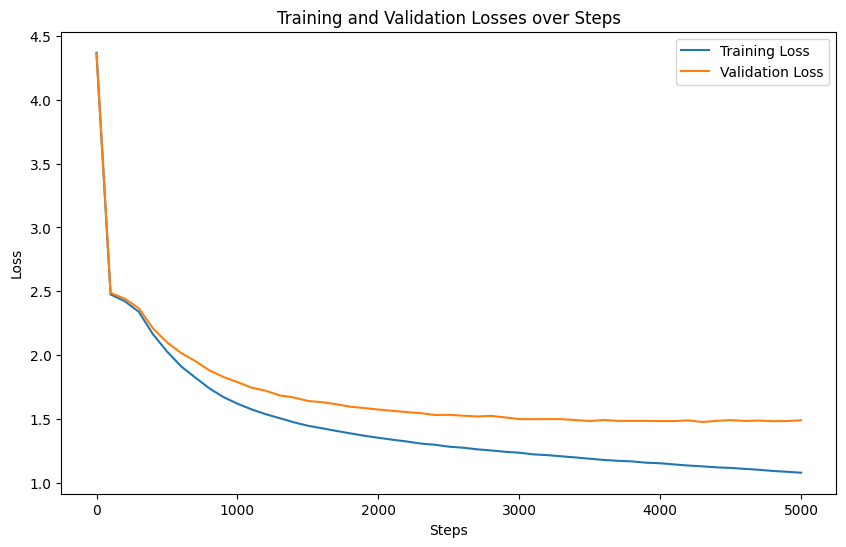

In [ ]:
import matplotlib.pyplot as plt

# Data
steps = [
    0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000,
    2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900,
    4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 4999
]
train_losses = [
    4.3679, 2.4757, 2.4235, 2.3399, 2.1654, 2.0296, 1.9132, 1.8260, 1.7415, 1.6730, 1.6209, 1.5760, 1.5386, 1.5072,
    1.4753, 1.4480, 1.4285, 1.4078, 1.3886, 1.3698, 1.3542, 1.3388, 1.3252, 1.3085, 1.2996, 1.2842, 1.2763, 1.2637,
    1.2546, 1.2442, 1.2371, 1.2241, 1.2179, 1.2088, 1.1998, 1.1896, 1.1802, 1.1737, 1.1690, 1.1587, 1.1545, 1.1451,
    1.1365, 1.1302, 1.1224, 1.1180, 1.1105, 1.1033, 1.0942, 1.0876, 1.0804
]
val_losses = [
    4.3585, 2.4884, 2.4428, 2.3684, 2.2108, 2.1012, 2.0180, 1.9548, 1.8818, 1.8303, 1.7895, 1.7463, 1.7225, 1.6857,
    1.6695, 1.6421, 1.6325, 1.6171, 1.5971, 1.5866, 1.5748, 1.5649, 1.5550, 1.5467, 1.5323, 1.5336, 1.5269, 1.5206,
    1.5254, 1.5131, 1.5003, 1.4992, 1.5003, 1.4995, 1.4925, 1.4854, 1.4929, 1.4862, 1.4861, 1.4862, 1.4846, 1.4850,
    1.4901, 1.4771, 1.4863, 1.4924, 1.4857, 1.4888, 1.4840, 1.4847, 1.4906
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Training Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Steps')
plt.legend()
plt.show()

##Analysis

The training and validation loss gradually decreased as the steps progressed which is promising. However, after step 3000, the validation loss began to oscillate betweem 1.48 and 1.49. This means very little to no changes were being made while training past this point.

The training time was approximately 21 minutes and 41 seconds which is relatively quick to train this model. However, I used the A100 GPU to train this model istead of the free GPUs that are provided by Google Colab. This could be the reason for the shorter training time.

The text the model generated shows signs of the model understanding the structure of the laguage. Actual words are being formed which is definately an improvement from the previous model created. However, the model fails to make a coherent statement that is gramatically correct.

This model would require more fine tuning, which could include more layers, greater training data or a longer training time for this models sentences to become coherent.